해당 파일은 연예인 이미지를 crop하여 저장해주는 파일입니다.

사용자가 직접 변수값을 입력해줘야 하는 부분은</br>**0.변수설정**입니다. 

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import cv2


workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### 0.변수설정 

In [2]:
# data_path: 연예인 폴더들을 포함하는 상위 폴더 경로
data_path = "/opt/ml/facenet_pytorch/data/actor_data"

# crop_data_path: 연예인 얼굴 crop한 사진을 저장할 폴더 경로
crop_data_path = "/opt/ml/facenet_pytorch/crop_data"

# min_size: crop 대상 이미지의 최소 width, height 사이즈
min_size = 100

# min_face_size: 얼굴 detection시 최소 얼굴 사이즈
min_face_size = 50

#### 1. MTCNN 모듈 및 InceptionResnetV1 모듈 정의

In [3]:
mtcnn = MTCNN(
    image_size=256, margin=80, min_face_size=min_face_size,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### 2. 사진이 없는 폴더 탐색

In [5]:
# 사진이 없는 경우 해당 폴더는 crop대상에서 제외
actor_names = []
remove_names = []
for actor_name in os.listdir(data_path):
    file_path = os.path.join(data_path, actor_name)
    if os.path.isdir(file_path):
        if len(os.listdir(file_path)) > 0: # 해당 폴더에 사진이 있는 경우
            actor_names.append(actor_name)
        else:
            remove_names.append(actor_name)

print(f'사진이 존재하는 배우: {len(actor_names)}명') # 818명
print(f'사진이 존재하지 않는 배우(삭제될 배우): {len(remove_names)}명') # 5명

사진이 존재하는 배우: 818명
사진이 존재하지 않는 배우(삭제될 배우): 5명


#### 3. Crop을 위한 custom Dataset정의 및 Data로드

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, data_path, select_names):
        self.mtcnn = mtcnn
        self.imgs, self.labels, self.file_name, self.idx_to_class = self.make_dataset(data_path, select_names)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        file_name = self.file_name[idx]
        return img, label, file_name

    def make_dataset(self, data_path, select_names):
        imgs = []
        labels = []
        file_name = []
        idx_to_class = {key:name for key, name in enumerate(select_names)}
        for key, name in idx_to_class.items():
            actor_path = os.path.join(data_path, name)
            for img_name in os.listdir(actor_path):
                # img의 차원이 3이 아니거나, 채널의 개수가 3이 아닌 경우 제외
                img_path = os.path.join(actor_path, img_name)
                img = cv2.imread(img_path)
                if type(img) == np.ndarray and len(img.shape) == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imgs.append(img)
                    labels.append(key)
                    file_name.append(img_path.split('/')[-1])

        return imgs, labels, file_name, idx_to_class

In [7]:
# total data 실행속도: 1m13s
dataset = CustomImageDataset(data_path, actor_names)

In [8]:
print(len(dataset.imgs))
print(len(dataset.labels))
print(len(dataset.file_name))

19725
19725
19725


In [9]:
print(f'crop대상 이미지 개수: {len(dataset.imgs)}') # 19725장
print(f'len(labels): {len(dataset.labels)}') # 19725
print(f'dataset.idx_to_class: {dataset.idx_to_class}')

crop대상 이미지 개수: 19725
len(labels): 19725
dataset.idx_to_class: {0: '이시언', 1: '김선아 - 1994년생', 2: '정소민', 3: '박민영', 4: '윤태영', 5: '이유영', 6: '차태현', 7: '강하늘', 8: '박시연', 9: '고은아 - 1988년생', 10: '남궁민', 11: '이광수', 12: '이혁재', 13: '유인영', 14: '김희선', 15: '윤주희', 16: '한수연', 17: '서인국', 18: '윤하', 19: '신은정', 20: '홍승희', 21: '조아영 - 1999년생', 22: '전혜진 - 1976년생', 23: '강민아', 24: '박세완', 25: '이시강', 26: '정소영', 27: '정지훈 - 비의 본명', 28: '김새론', 29: '엄태웅', 30: '김예원', 31: '양현민', 32: '조진웅', 33: '이호철', 34: '이승기', 35: '이지훈 - 19790327', 36: '한주완', 37: '황우슬혜', 38: '윤두준', 39: '조한선', 40: '김성철', 41: '최강창민', 42: '조여정', 43: '기은세', 44: '서지혜', 45: '차학연', 46: '연민지', 47: '김가희', 48: '황선희', 49: '장가현', 50: '박수진', 51: '최현욱', 52: '곽지민', 53: '조동혁', 54: '이수민_2001년생', 55: '윤계상', 56: '류준열', 57: '이희준', 58: '이상우', 59: '김현중', 60: '임윤아', 61: '구혜선', 62: '박선영 - 1976년생', 63: '김규리 - 1979년 6월생', 64: '성준', 65: '전종서', 66: '윤박', 67: '최송현', 68: '임주환', 69: '박규영', 70: '진지희', 71: '서정연', 72: '박정민', 73: '김준', 74: '이민지', 75: '김소혜', 76: '강지영', 77: '임진아', 78: '박보영

In [10]:
def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers, batch_size=1)

#### 4. Crop 수행 및 수행결과 확인

In [17]:
# 19725장 -> 9m30s
aligned = []
names = []
file_names = []

for img, label, file_name in loader:
    if img.shape[0] < min_size or img.shape[1] < min_size:
        continue

    x_aligned, prob = mtcnn(img, return_prob=True)
    
    if x_aligned is not None:
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[label])
        file_names.append(file_name)

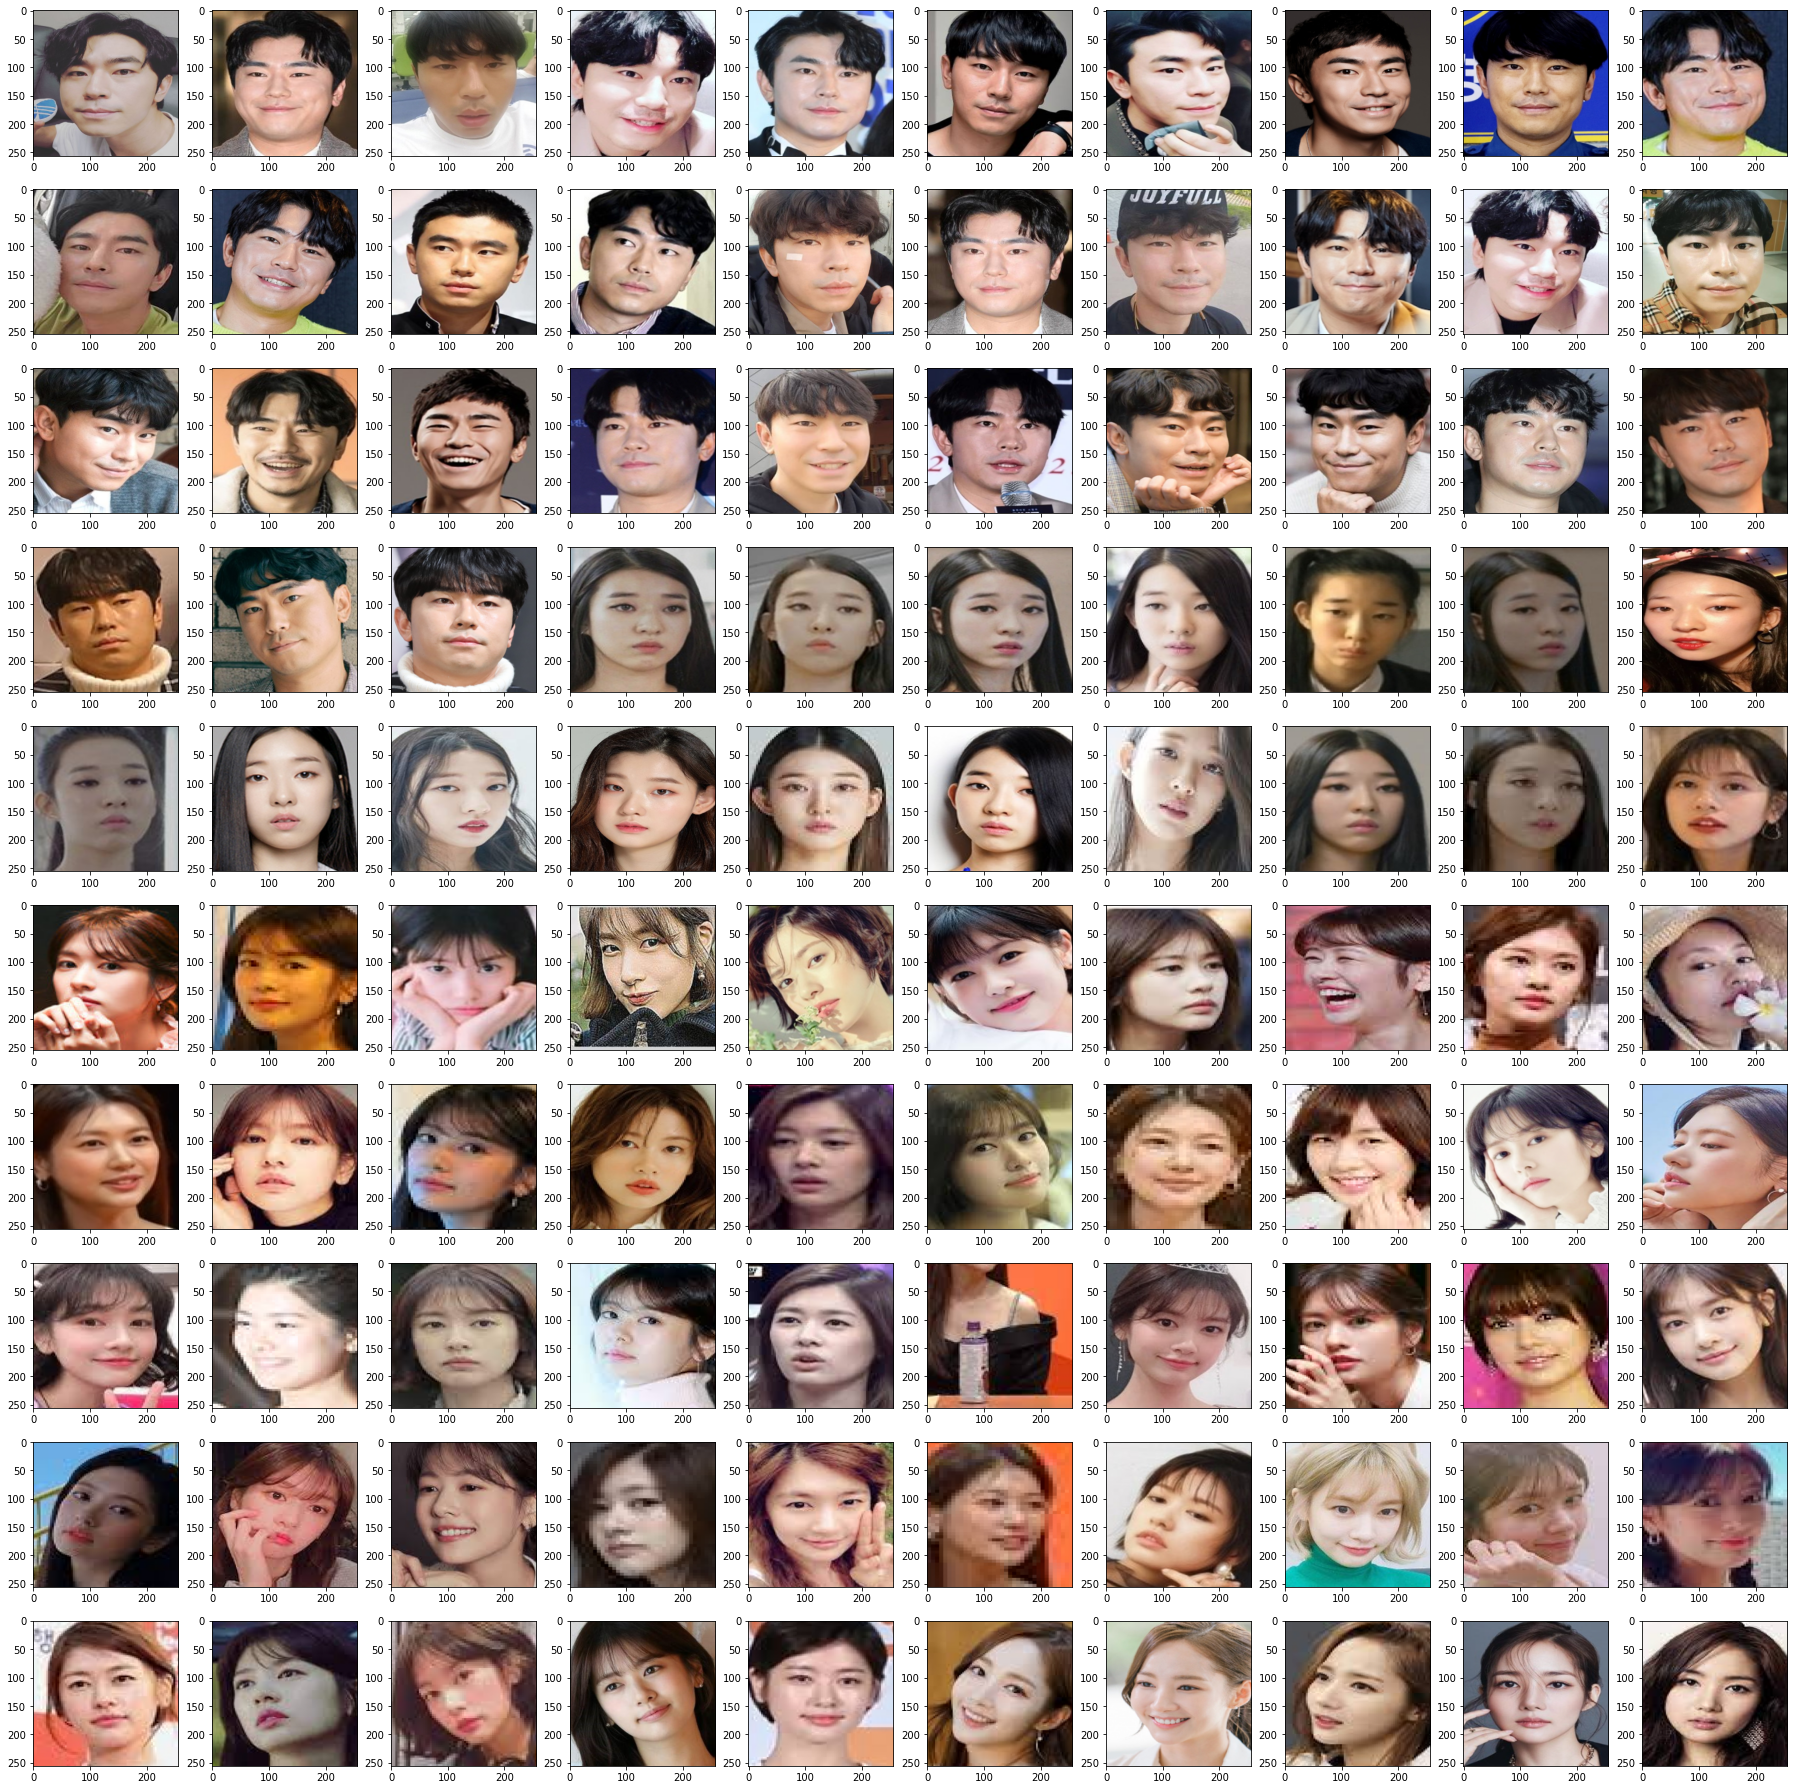

In [18]:
row_size = 10
col_size = min(10, math.ceil(len(aligned)//row_size))
fig, ax = plt.subplots(row_size, col_size, figsize=(25, 25)) 
for i, output in enumerate(aligned[:100]):
    ax[i//row_size][i%col_size].imshow((output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))

fig.tight_layout()
plt.show()

In [19]:
print(f'np.array(aligned).shape: {np.array(aligned).shape}')  # 19725장 -> 19488
print(f'len(names): {len(names)}')  # 19488
print(f'len(file_names): {len(file_names)}')  # 19488

np.array(aligned_100).shape: (19488,)
len(names_100): 19488
len(file_names_100): 19488


/opt/conda/envs/final/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/final/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [46]:
set(map(lambda x: x.split('.')[-1], file_names))

{'JPG', 'jfif', 'jpeg', 'jpg', 'png'}

In [47]:
for i, output in enumerate(aligned):
    if file_names[i].split('.')[-1] not in ['JPG', 'jpeg', 'jpg', 'png']:
        continue
    save_img = (output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0))[...,[2,1,0]]
    folder_path = os.path.join(crop_data_path, names[i])
    img_path = os.path.join(folder_path, file_names[i])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    print(img_path)
    cv2.imwrite(img_path, save_img)
    

/opt/ml/facenet_pytorch/crop_data/이시언/이시언31.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언24.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언29.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언2.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언51.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언57.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언10.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언52.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언38.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언56.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언25.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언11.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언53.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언43.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언50.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언12.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언14.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언5.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언28.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언55.jpg
/opt/ml/facenet_pytorch/crop_data/이시언/이시언3